Starting Training on CPU...

[1/10] [0/157] Loss_D: 1.2662 | Loss_G: 3.4899
[1/10] [50/157] Loss_D: 0.0163 | Loss_G: 6.9925
[1/10] [100/157] Loss_D: 0.0036 | Loss_G: 7.4900
[1/10] [150/157] Loss_D: 0.0042 | Loss_G: 8.1104
[2/10] [0/157] Loss_D: 1.1500 | Loss_G: 23.5880
[2/10] [50/157] Loss_D: 0.2033 | Loss_G: 4.0134
[2/10] [100/157] Loss_D: 0.4352 | Loss_G: 2.5196
[2/10] [150/157] Loss_D: 0.7254 | Loss_G: 2.6731
[3/10] [0/157] Loss_D: 0.5939 | Loss_G: 2.0433
[3/10] [50/157] Loss_D: 0.7639 | Loss_G: 4.0082
[3/10] [100/157] Loss_D: 1.0317 | Loss_G: 2.4967
[3/10] [150/157] Loss_D: 0.5720 | Loss_G: 2.0799
[4/10] [0/157] Loss_D: 2.2843 | Loss_G: 0.4885
[4/10] [50/157] Loss_D: 0.2423 | Loss_G: 2.5881
[4/10] [100/157] Loss_D: 0.2028 | Loss_G: 2.4956
[4/10] [150/157] Loss_D: 0.6757 | Loss_G: 1.7650
[5/10] [0/157] Loss_D: 1.1877 | Loss_G: 2.5326
[5/10] [50/157] Loss_D: 0.3563 | Loss_G: 2.3928
[5/10] [100/157] Loss_D: 1.2744 | Loss_G: 3.3167
[5/10] [150/157] Loss_D: 0.4471 | Loss_G: 1.8037
[6/10

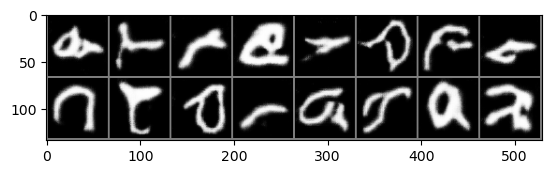

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.datasets import EMNIST
import matplotlib.pyplot as plt
import numpy as np
import time

# Ensure we use CPU only
device = torch.device("cpu")

# Visualize the generated images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

# Hyperparameters
nz = 100
ngf = 64
ndf = 64
nc = 1  # Grayscale (EMNIST)
lr = 0.0002
beta1 = 0.5
batch_size = 64
epochs = 10

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = EMNIST(root='./data', split='balanced', download=True, transform=transform)
indices = torch.randperm(len(dataset))[:10000]  # Select 10,000 random samples
dataset = Subset(dataset, indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Create Generator and Discriminator
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Start Timing
start_time = time.time()

# Training loop
print("Starting Training on CPU...\n")
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        netD.zero_grad()
        real_labels = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        real_output = netD(real_images)
        real_loss = criterion(real_output, real_labels)
        real_loss.backward()
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        fake_labels = torch.full((batch_size,), 0, dtype=torch.float, device=device)
        fake_output = netD(fake_images.detach())
        fake_loss = criterion(fake_output, fake_labels)
        fake_loss.backward()
        
        D_loss = real_loss + fake_loss
        optimizerD.step()
        
        # Train Generator
        netG.zero_grad()
        G_labels = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        G_output = netD(fake_images)
        G_loss = criterion(G_output, G_labels)
        G_loss.backward()
        optimizerG.step()

        # Print progress
        if i % 50 == 0:
            print(f"[{epoch+1}/{epochs}] [{i}/{len(dataloader)}] Loss_D: {D_loss.item():.4f} | Loss_G: {G_loss.item():.4f}")

# End Timing
end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time):.2f} seconds.")

# Generate images after training
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake_images = netG(noise).detach().cpu()

# Visualize the generated images
generated_grid = torchvision.utils.make_grid(fake_images[:64], nrow=8, padding=2)
imshow(generated_grid)

# Save trained models
torch.save(netG.state_dict(), "dcgan_generator_cpu.pth")
torch.save(netD.state_dict(), "dcgan_discriminator_cpu.pth")
